In [1]:
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
img_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
        transforms.Lambda(lambda x: x.to(device)),
    ]
)

In [3]:
trn_ds = MNIST("data/mnist/", transform=img_transform, train=True, download=True)
val_ds = MNIST("data/mnist/", transform=img_transform, train=False, download=True)

In [4]:
batch_size = 256
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [14]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latend_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = x.flatten(1, -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 1, 28, 28)
        return x

In [9]:
from torchinfo import summary
import torch

model = AutoEncoder(3).to(device)
summary(model, input_size=(2, 1, 28, 28), device="cuda")

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [2, 1, 28, 28]            --
├─Sequential: 1-1                        [2, 3]                    --
│    └─Linear: 2-1                       [2, 128]                  100,480
│    └─ReLU: 2-2                         [2, 128]                  --
│    └─Linear: 2-3                       [2, 64]                   8,256
│    └─ReLU: 2-4                         [2, 64]                   --
│    └─Linear: 2-5                       [2, 3]                    195
├─Sequential: 1-2                        [2, 784]                  --
│    └─Linear: 2-6                       [2, 64]                   256
│    └─ReLU: 2-7                         [2, 64]                   --
│    └─Linear: 2-8                       [2, 128]                  8,320
│    └─ReLU: 2-9                         [2, 128]                  --
│    └─Linear: 2-10                      [2, 784]                  101,1

In [10]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

EPOCH: 1.000  trn_loss: 0.235  val_loss: 0.141  (16.66s - 66.65s remaining)
EPOCH: 2.000  trn_loss: 0.124  val_loss: 0.111  (33.26s - 49.89s remaining)
EPOCH: 3.000  trn_loss: 0.104  val_loss: 0.097  (49.34s - 32.89s remaining)
EPOCH: 4.000  trn_loss: 0.095  val_loss: 0.091  (63.69s - 15.92s remaining)
EPOCH: 5.000  trn_loss: 0.090  val_loss: 0.087  (79.47s - 0.00s remaining)


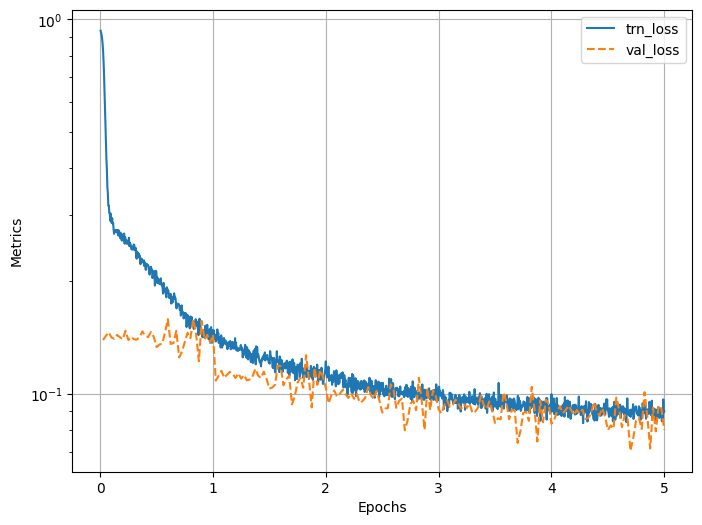

In [15]:
model = AutoEncoder(10).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix + 1) / N), trn_loss=loss, end="\r")

    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix + 1) / N), val_loss=loss, end="\r")
    log.report_avgs(epoch + 1)
log.plot(log=True)

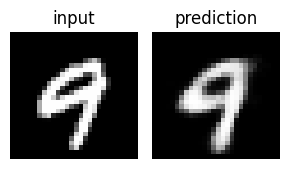

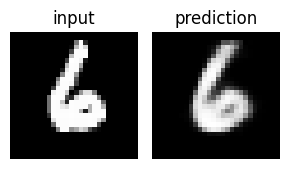

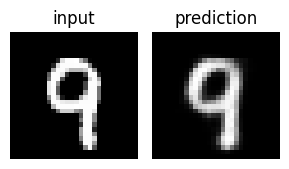

In [16]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1, 2, figsize=(3, 3))
    show(im[0], ax=ax[0], title="input")
    show(_im[0], ax=ax[1], title="prediction")
    plt.tight_layout()
    plt.show()